<a href="https://colab.research.google.com/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Removables**

In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 20782 (delta 24), reused 29 (delta 14), pack-reused 20737
Receiving objects: 100% (20782/20782), 16.58 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (15168/15168), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728),

In [ ]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grahamfernando","key":"cffa546ccec7808cfc8cec9944ed384a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c m5-forecasting-accuracy

  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 60.3MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 106MB/s]
 32% 5.00M/15.5M [00:01<00:03, 3.64MB/s]
100% 15.5M/15.5M [00:01<00:00, 10.7MB/s]
 57% 9.00M/15.8M [00:00<00:00, 15.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 27.0MB/s]
 63% 9.00M/14.2M [00:00<00:00, 18.9MB/s]
100% 14.2M/14.2M [00:00<00:00, 29.0MB/s]


In [ ]:
!unzip sales_train_evaluation.csv.zip
!unzip sales_train_validation.csv.zip
!unzip sample_submission.csv.zip
!unzip sell_prices.csv.zip

Archive:  sales_train_evaluation.csv.zip
  inflating: sales_train_evaluation.csv  
Archive:  sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         


In [ ]:
! pip install downcast

# **Importing modules required and reading the files.**

In [ ]:
import numpy as np
import pandas as pd
from downcast import reduce
from datetime import timedelta
from tqdm import tqdm
import pickle
# import dask.dataframe as dd
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, Dataset, train, plot_importance
from sklearn.model_selection import GridSearchCV
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Using Pandas to reasd the files.

sales = pd.read_csv("sales_train_evaluation.csv")
sell_price = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

# **Feature Engineering**

In [ ]:
# We are creating new features required for the prediction for days from 1942 till 1969

for i in range(1942, 1942+28):
    sales['d_'+str(i)] = np.int8(0)

In [ ]:
# To reduce the memory usage, we'll be using reduce throughout the code

sales = reduce(sales)

In [ ]:
# We are transforming our Time Series problem to Supervised Machine Learning Problem

data = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
          var_name='day', value_name='demand').dropna()
print("The new shape is ",data.shape)
data.head(2)

The new shape is  (60034810, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
data = reduce(data)

# We are filling the places of NaN values with No_Events
cal.fillna('No_Event', inplace=True)

cal = reduce(cal)

In [ ]:
# We are then merging the all the csv files together

data = data.merge(cal, left_on='day', right_on='d')

sell_price = reduce(sell_price)

data = data.merge(sell_price,on=['store_id','item_id', 'wm_yr_wk'], how='left')

In [ ]:
print(f" There are {data['sell_price'].isna().sum()} missing values in sell_price column")

 There are 12299413 missing values in sell_price column


In [ ]:
# We are filling the missing places in sell_price feature with grouped id mean value.

data['sell_price'].fillna(data.groupby('id')['sell_price'].transform('mean'), inplace=True)
print(f" There are {data['sell_price'].isna().sum()} missing values in sell_price column")
print(f"There are {data.isna().sum().sum()} missing values in the data")

In [ ]:
# we are stripping the 'd_' from day column to make it an integer feature
data['day'] = data['day'].str.split('_').str[1].astype(np.int16)

#since weekday's are represented as wday with numbers and d is a duplicate column.
data.drop(['d','weekday'], axis=1, inplace=True) 

# We are picking data after 500 days as from EDA we found that early period there was not much of a cycle being followed
data = data[data['day'] > 500]
data.head(2)

In [ ]:
# Adding lag shift features as those are good time series feature engineering steps.

lags = [1,2,3,5,7,10,14,21,30,180,365]
for lag in lags:
    data["lag_" + str(lag)] = data.groupby("id")["demand"].shift(lag).astype(np.float16)

In [ ]:
# Adding rolling window feature with mean value

means = [5,7,10,14]
for mns in tqdm(means):
    data['rolling_mean_'+str(mns)] = data.groupby(['id'])['demand'].transform(lambda x: x.rolling(mns).mean())

100%|██████████| 4/4 [2:15:45<00:00, 2036.32s/it]


In [ ]:
data.to_pickle('new.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp new.pkl /content/drive/MyDrive

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/new.pkl')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_2,lag_3,lag_5,lag_7,lag_10,lag_14,lag_21,lag_30,lag_180,lag_365,rolling_mean_5,rolling_mean_7,rolling_mean_10,rolling_mean_14
15245000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,501,0,2012-06-12,11220,4,6,2012,NBAFinalsStart,Sporting,No_Event,No_Event,0,1,1,8.281250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15245001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,501,0,2012-06-12,11220,4,6,2012,NBAFinalsStart,Sporting,No_Event,No_Event,0,1,1,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# On EDA we found that sales were high on weekends, so we are creating a feature if it's a weekend
# Here Monday is represented as 1 and it goes on till Sunday as 7, hence passing condition greater than equal 6 represents 6 to be Saturday and 7 to be Sunday.

data['weekend'] = data['wday'].apply(lambda x:1 if x >= 6 else 0)

In [ ]:
# We are creating new column for the date and week of the year as they followed a seasonal cycle we found on our EDA

data['week'] = data['date'].dt.isocalendar().week.astype(np.int16)
data['dte'] = data['date'].dt.day

data = reduce(data)

In [ ]:
#  We are doing a categorical encoding by replacing the categories with the memory number every category has.
 
 for i in data.columns:
    try:
        data[i] = data[i].cat.codes
    except AttributeError:
        pass

In [ ]:
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_2,lag_3,lag_5,lag_7,lag_10,lag_14,lag_21,lag_30,lag_180,lag_365,rolling_mean_5,rolling_mean_7,rolling_mean_10,rolling_mean_14,weekend,week,dte
15245000,14370,1437,3,1,0,0,501,0,2012-06-12,11220,4,6,2012,17,4,3,1,0,1,1,8.281250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24,12
15245001,14380,1438,3,1,0,0,501,0,2012-06-12,11220,4,6,2012,17,4,3,1,0,1,1,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24,12


In [ ]:
# We are taking only the last 1000 days of data as the data is huge and memory usage gets heavy.
# So we are finding the 1000th date from the last.
(data.iloc[[-1],8]-timedelta(1000))

60034809   2013-09-23
Name: date, dtype: datetime64[ns]

In [ ]:
# We will now be working on data which was recorded only after "2013-09-23"
data = data[data['date'] > '2013-09-23']

In [ ]:
# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

# Records till day 1914 will be used for training the model.
X_train = data[data['day']<1914]

# Records between days 1914 and 1941 will be used for Validation
X_val = data[(data['day']>=1914) & (data['day']<=1941)]

# Records after day 1942 will used for final test
X_test = data[(data['day']>=1942)]

In [ ]:
y_train = X_train['demand']
y_val = X_val['demand']

# We are drpping the features which are not required.
X_train.drop(['id', 'day','demand', 'wm_yr_wk','date'],axis = 1,inplace = True)
X_val.drop(['id', 'day','demand', 'wm_yr_wk','date'],axis = 1,inplace = True)
X_test.drop(['id', 'day','demand', 'wm_yr_wk','date'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(28782560, 34) (28782560,)
(853720, 34) (853720,)
(853720, 34)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
del data

In [ ]:
# We are now running our LightGBM model with multiple learning rate and max depth values to get the best parameter.

lr = [0.05, 0.1]
md = [3, 5, 7]

for i in lr:
    for j in tqdm(md):
        lgb = LGBMRegressor(objective = 'tweedie', learning_rate = i, max_depth = j ,subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 1300)
        lgb.fit(X_train,y_train, verbose = False)
        y_pred = lgb.predict(X_val)
        rmse = mean_squared_error(y_val,y_pred)
        print(f"For learning_rate {i} and max_depth {j}, the rmse is {rmse}")
        print("*" * 50)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [42:47<1:25:35, 2567.93s/it]

For learning_rate 0.05 and max_depth 3, the rmse is 2.1457554751556356
**************************************************




 67%|██████▋   | 2/3 [1:31:25<44:32, 2672.81s/it]

For learning_rate 0.05 and max_depth 5, the rmse is 1.880183902980925
**************************************************




100%|██████████| 3/3 [2:21:55<00:00, 2838.64s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

For learning_rate 0.05 and max_depth 7, the rmse is 1.8947060686444024
**************************************************




 33%|███▎      | 1/3 [41:40<1:23:20, 2500.08s/it]

For learning_rate 0.1 and max_depth 3, the rmse is 1.9579735967749583
**************************************************




 67%|██████▋   | 2/3 [1:28:52<43:19, 2599.76s/it]

For learning_rate 0.1 and max_depth 5, the rmse is 1.8455936142800922
**************************************************




100%|██████████| 3/3 [2:16:15<00:00, 2725.08s/it]

For learning_rate 0.1 and max_depth 7, the rmse is 1.7928927943904127
**************************************************


In [ ]:
# We are retraining the model with best parameter we got.

lgb = LGBMRegressor(objective = 'tweedie', learning_rate = 0.1, max_depth = 7,subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 1300)
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_val)
rmse = mean_squared_error(y_val,y_pred)
print(f'The rmse value for the best model is {rmse}')

The rmse value for the best model is 1.7928927943902502


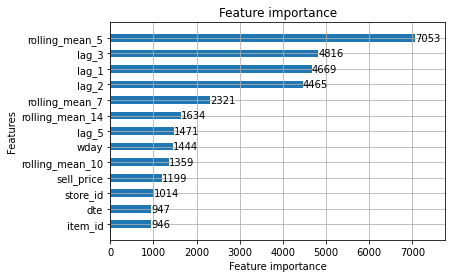

In [ ]:
# Plot importance helps us plot the top features. Here we are plotting the top 13 features and setting the bar width to be 0.5
plot_importance(lgb,max_num_features = 13, height = 0.5)
plt.show()

In [ ]:
pred_val  = lgb.predict(X_val)
pred_test  = lgb.predict(X_test)

pred_val = np.reshape(pred_val, (-1, 28),order = 'F')
pred_test = np.reshape(pred_test, (-1, 28),order = 'F')

In [ ]:
sales = pd.read_csv("sales_train_evaluation.csv")
sell_price = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

In [ ]:
d_cols = [d for d in sales.columns if 'd_' in d][-28:]
preds_val = pd.DataFrame(pred_val,columns = d_cols)
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, sell_price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1914-1941]:",score)



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:00<00:09,  1.21it/s]

 17%|█▋        | 2/12 [00:01<00:08,  1.19it/s]

 25%|██▌       | 3/12 [00:02<00:07,  1.18it/s]

 33%|███▎      | 4/12 [00:03<00:06,  1.17it/s]

 42%|████▏     | 5/12 [00:04<00:06,  1.16it/s]

 50%|█████     | 6/12 [00:05<00:05,  1.15it/s]

 58%|█████▊    | 7/12 [00:06<00:04,  1.15it/s]

 67%|██████▋   | 8/12 [00:06<00:03,  1.14it/s]

 75%|███████▌  | 9/12 [00:07<00:02,  1.14it/s]

 83%|████████▎ | 10/12 [00:09<00:02,  1.18s/it]

 92%|█████████▏| 11/12 [00:13<00:01,  1.90s/it]

100%|██████████| 12/12 [00:24<00:00,  2.06s/it]


WRMSSE score of validation data [for days 1914-1941]: 0.5030958018804834


In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_val = sub.iloc[:30490,:]
sub_eval = sub.iloc[30490:,:]
col = sub.columns[1:]

for i in range(len(col)):
    sub_val.loc[:,col[i]] = pred_val[:,i]
    sub_eval.loc[:,col[i]] = pred_test[:,i]

sub = pd.concat([sub_val,sub_eval])
sub.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.596353e+00,0.000499,3.979962e-01,1.240907e+00,2.712481e-07,1.979741,3.412549e+00,1.089272e+00,1.091318e-01,1.509766,1.323719e+00,1.534896e-03,1.248288e+00,1.113930,1.609422e+00,8.470861e-01,1.086064e+00,3.937205e-01,2.003714e+00,3.934808,0.538177,0.028695,0.772779,1.553171e+00,1.155071,1.804689,0.063043,4.283264e-01
1,HOBBIES_1_002_CA_1_validation,1.484903e-12,0.464026,3.746529e-09,2.525191e-09,1.565138e-09,0.603419,1.976562e-12,5.856186e-12,6.089676e-14,0.428070,2.017015e-09,4.750798e-10,1.666688e-10,0.557306,1.476543e-12,4.225602e-12,5.814091e-14,6.593128e-14,7.188925e-14,0.586204,1.386450,0.450999,0.381475,3.672306e-01,0.775446,0.494463,0.607505,2.427175e-11
2,HOBBIES_1_003_CA_1_validation,5.578266e-02,0.400337,7.446245e-01,8.198995e-01,1.069218e-03,1.146013,1.172020e+00,4.338775e-01,2.974171e-03,0.835626,2.004604e-01,9.949081e-01,5.872306e-01,1.715278,1.323587e-01,7.853967e-01,6.869497e-01,1.284461e+00,5.232923e-01,0.004354,2.092520,0.006205,0.445832,1.693686e-07,1.555756,1.600449,0.052388,4.640114e-01


In [ ]:
sub.to_csv("lgb_sub.csv",index = False)

In [ ]:
sub.to_excel("lgb_sub.xlsx",index = False)

In [ ]:
pd.read_csv('lgb_sub.csv')

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.596353e+00,4.986457e-04,3.979962e-01,1.240907e+00,2.712481e-07,1.979741e+00,3.412549e+00,1.089272e+00,1.091318e-01,1.509766e+00,1.323719e+00,1.534896e-03,1.248288e+00,1.113930e+00,1.609422e+00,8.470861e-01,1.086064e+00,3.937205e-01,2.003714e+00,3.934808e+00,5.381766e-01,2.869521e-02,7.727790e-01,1.553171e+00,1.155071e+00,1.804689e+00,6.304260e-02,4.283264e-01
1,HOBBIES_1_002_CA_1_validation,1.484903e-12,4.640264e-01,3.746529e-09,2.525191e-09,1.565138e-09,6.034192e-01,1.976562e-12,5.856186e-12,6.089676e-14,4.280701e-01,2.017015e-09,4.750798e-10,1.666688e-10,5.573064e-01,1.476543e-12,4.225602e-12,5.814091e-14,6.593128e-14,7.188925e-14,5.862043e-01,1.386450e+00,4.509986e-01,3.814747e-01,3.672306e-01,7.754459e-01,4.944626e-01,6.075052e-01,2.427175e-11
2,HOBBIES_1_003_CA_1_validation,5.578266e-02,4.003369e-01,7.446245e-01,8.198995e-01,1.069218e-03,1.146013e+00,1.172020e+00,4.338775e-01,2.974171e-03,8.356261e-01,2.004604e-01,9.949081e-01,5.872306e-01,1.715278e+00,1.323587e-01,7.853967e-01,6.869497e-01,1.284461e+00,5.232923e-01,4.353943e-03,2.092520e+00,6.204873e-03,4.458317e-01,1.693686e-07,1.555756e+00,1.600449e+00,5.238841e-02,4.640114e-01
3,HOBBIES_1_004_CA_1_validation,7.738518e-01,1.045057e+00,2.994545e+00,1.695847e+00,2.337350e+00,6.798969e-01,4.394699e+00,2.943293e+00,1.719187e+00,4.526303e-01,1.246495e+00,2.785707e+00,1.248907e+00,2.398815e+00,1.010314e+00,1.350997e+00,1.051158e+00,1.927224e+00,1.442877e+00,1.157984e+00,5.637536e-01,3.083722e+00,4.135854e-01,7.835344e-01,1.106244e+00,2.117077e+00,1.031353e+00,4.382867e+00
4,HOBBIES_1_005_CA_1_validation,1.363209e+00,8.732985e-01,1.482665e+00,2.995958e+00,1.000434e+00,2.378676e-01,3.414341e+00,2.862571e+00,2.001170e+00,5.136738e-01,8.195201e-01,2.298245e+00,2.804716e+00,2.139635e+00,1.558306e+00,2.289041e+00,1.527702e+00,1.977803e+00,9.932435e-01,1.042951e+00,1.034284e+00,1.900206e+00,4.945145e-01,4.407262e-03,4.123911e-03,2.184378e+00,1.152484e+00,4.039853e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,1.271138e-03,1.206223e-03,3.944581e-01,3.937634e-01,2.034221e-11,6.095006e-12,6.231406e-14,6.151171e-14,5.569997e-14,3.049498e-14,3.257644e-14,3.537025e-14,2.401388e-14,1.788027e-14,1.672914e-14,1.456477e-14,2.364111e-14,2.090794e-14,2.151525e-14,1.644973e-14,1.674476e-14,1.741466e-14,2.069284e-14,2.278499e-14,1.907090e-14,1.989529e-14,1.552405e-14,1.471634e-14
60976,FOODS_3_824_WI_3_evaluation,5.472751e-01,6.579931e-08,4.176044e-01,1.006226e-12,4.757173e-12,5.533876e-14,5.377883e-14,5.527491e-14,2.033362e-14,3.011038e-14,3.207961e-14,3.617037e-14,1.934841e-14,1.741919e-14,1.690177e-14,1.506729e-14,2.130523e-14,2.084087e-14,2.035563e-14,1.648668e-14,1.701124e-14,1.559526e-14,1.777194e-14,2.129347e-14,1.942486e-14,2.026455e-14,1.519675e-14,1.474940e-14
60977,FOODS_3_825_WI_3_evaluation,6.229284e-03,4.612292e-01,2.629367e-07,8.193034e-01,1.358494e-11,2.243694e-11,6.311946e-14,6.266022e-14,6.252466e-14,3.129337e-14,3.459013e-14,3.502182e-14,2.631000e-14,1.709371e-14,1.732101e-14,1.528696e-14,2.084018e-14,2.253854e-14,2.133534e-14,1.737000e-14,1.824495e-14,1.541740e-14,1.803105e-14,2.558417e-14,1.983391e-14,2.133413e-14,1.514444e-14,1.450899e-14
60978,FOODS_3_826_WI_3_evaluation,5.022870e-01,3.662490e-01,3.790535e-01,2.891505e-11,8.986696e-12,1.024207e-13,1.159049e-13,8.707605e-14,2.226942e-14,3.338474e-14,3.389309e-14,3.803082e-14,2.024680e-14,1.784721e-14,1.798835e-14,1.771502e-14,2.302884e-14,2.391971e-14,2.240820e-14,1.806547e-14,1.863347e-14,1.646631e-14,1.852559e-14,2.420900e-14,2.213794e-14,2.210767e-14,1.721472e-14,1.671883e-14


In [ ]:
from typing import Union

In [ ]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)